# Contributes progeny by cell
This notebook annotates each infected cell by whether it contributes any progeny to the supernatant and second_infection

Import python modules:


In [1]:
from IPython.display import display

from dms_variants.constants import CBPALETTE

import pandas as pd

import plotnine as p9

Hardcode variables for now:

In [2]:
transcription_progeny_csv = snakemake.input.transcription_progeny_csv
viral_genes_by_cell_csv = snakemake.input.viral_genes_by_cell_csv
expt = snakemake.wildcards.expt
plot = snakemake.output.plot
progeny_detection_limit = float(snakemake.params.progeny_detection_limit)
contributes_progeny_by_cell_csv = snakemake.output.contributes_progeny_by_cell_csv

Style parameters. *N.b.* `CBPALETTE` is defined in imports above.

In [3]:
p9.theme_set(p9.theme_classic())

## Load data
Load data on viral barcodes in each infected cell and frequency of those viral barcodes in each progeny sample.  

In [4]:
viral_barcode_freqs = pd.read_csv(transcription_progeny_csv)
display(viral_barcode_freqs)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,gene,source,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,progeny_freq
0,AAACGAAGTAGACGTG,infected,wt,124341,4654,0.037429,fluHA,second_infection,AAGTAAGCGACATGAG,251.0,0.002019,0.00001
1,AAAGGATTCTGATGGT,infected,syn,80029,3893,0.048645,fluHA,second_infection,GTGGAGTCGCCAGTTC,114.0,0.001424,0.00001
2,AAAGGGCCAGGCTACC,infected,wt,20241,355,0.017539,fluHA,second_infection,AAAGTGATCCCCATAC,8.0,0.000395,0.00001
3,AAAGGGCCAGGCTACC,infected,wt,20241,355,0.017539,fluHA,second_infection,CATTTAACGCTGTGAG,15.0,0.000741,0.00001
4,AAAGGGCCAGGCTACC,infected,wt,20241,355,0.017539,fluHA,second_infection,CGTAGGATGTTGCGTC,31.0,0.001532,0.00001
...,...,...,...,...,...,...,...,...,...,...,...,...
2261,TTTAGTCCATCATCCC,infected,wt,23766,1216,0.051166,fluNA,supernatant,TTGGACGCATTGCAAA,18.0,0.000757,0.00001
2262,TTTAGTCGTGCTCCGA,infected,wt,195173,6905,0.035379,fluNA,supernatant,NaN,NaN,NaN,NaN
2263,TTTCACAAGCCAAGCA,infected,wt,68424,2308,0.033731,fluNA,supernatant,GGTATCAGTTATTGTT,186.0,0.002718,0.00001
2264,TTTGATCTCGCATTGA,infected,wt,170914,10415,0.060937,fluNA,supernatant,NaN,NaN,NaN,NaN


Load viral gene presence/absence data

In [5]:
viral_genes_by_cell = pd.read_csv(viral_genes_by_cell_csv)
display(viral_genes_by_cell)

,cell_barcode,n_viral_genes,gene,frac_gene_UMIs,gene_present
0,AAACCCAGTAACAAGT,0,fluPB2,0.000000,False
1,AAACCCATCATTGCTT,1,fluPB2,0.000011,True
2,AAACGAAAGATGTTGA,0,fluPB2,0.000000,False
3,AAACGAAGTACTTCCC,7,fluPB2,0.002816,True
4,AAACGAAGTAGACGTG,8,fluPB2,0.000024,True
...,...,...,...,...,...
26971,TTTGATCTCCCGTTCA,0,fluNS,0.000016,False
26972,TTTGATCTCGCATTGA,8,fluNS,0.013147,True
26973,TTTGGAGAGTTGCCTA,1,fluNS,0.000061,False
26974,TTTGGAGGTATCGTTG,8,fluNS,0.008193,True


Merge viral gene data into viral progeny data:

In [6]:
viral_barcode_freqs = pd.merge(
    left=viral_barcode_freqs,
    right=viral_genes_by_cell,
    on=['cell_barcode', 'gene'],
    how='left',
    validate='many_to_one'
)
display(viral_barcode_freqs)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,gene,source,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,progeny_freq,n_viral_genes,frac_gene_UMIs,gene_present
0,AAACGAAGTAGACGTG,infected,wt,124341,4654,0.037429,fluHA,second_infection,AAGTAAGCGACATGAG,251.0,0.002019,0.00001,8,0.002566,True
1,AAAGGATTCTGATGGT,infected,syn,80029,3893,0.048645,fluHA,second_infection,GTGGAGTCGCCAGTTC,114.0,0.001424,0.00001,8,0.003511,True
2,AAAGGGCCAGGCTACC,infected,wt,20241,355,0.017539,fluHA,second_infection,AAAGTGATCCCCATAC,8.0,0.000395,0.00001,8,0.003607,True
3,AAAGGGCCAGGCTACC,infected,wt,20241,355,0.017539,fluHA,second_infection,CATTTAACGCTGTGAG,15.0,0.000741,0.00001,8,0.003607,True
4,AAAGGGCCAGGCTACC,infected,wt,20241,355,0.017539,fluHA,second_infection,CGTAGGATGTTGCGTC,31.0,0.001532,0.00001,8,0.003607,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2261,TTTAGTCCATCATCCC,infected,wt,23766,1216,0.051166,fluNA,supernatant,TTGGACGCATTGCAAA,18.0,0.000757,0.00001,7,0.001389,True
2262,TTTAGTCGTGCTCCGA,infected,wt,195173,6905,0.035379,fluNA,supernatant,NaN,NaN,NaN,NaN,8,0.000005,True
2263,TTTCACAAGCCAAGCA,infected,wt,68424,2308,0.033731,fluNA,supernatant,GGTATCAGTTATTGTT,186.0,0.002718,0.00001,6,0.003201,True
2264,TTTGATCTCGCATTGA,infected,wt,170914,10415,0.060937,fluNA,supernatant,NaN,NaN,NaN,NaN,8,0.007864,True


## Detect viral barcodes in cells

Annotate whether each cell has a viral barcode detected on each barcoded gene:

In [7]:
viral_barcode_freqs = viral_barcode_freqs.assign(
    viral_bc_detected=lambda x: x['viral_barcode'].notnull()
)
display(viral_barcode_freqs)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,gene,source,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,progeny_freq,n_viral_genes,frac_gene_UMIs,gene_present,viral_bc_detected
0,AAACGAAGTAGACGTG,infected,wt,124341,4654,0.037429,fluHA,second_infection,AAGTAAGCGACATGAG,251.0,0.002019,0.00001,8,0.002566,True,True
1,AAAGGATTCTGATGGT,infected,syn,80029,3893,0.048645,fluHA,second_infection,GTGGAGTCGCCAGTTC,114.0,0.001424,0.00001,8,0.003511,True,True
2,AAAGGGCCAGGCTACC,infected,wt,20241,355,0.017539,fluHA,second_infection,AAAGTGATCCCCATAC,8.0,0.000395,0.00001,8,0.003607,True,True
3,AAAGGGCCAGGCTACC,infected,wt,20241,355,0.017539,fluHA,second_infection,CATTTAACGCTGTGAG,15.0,0.000741,0.00001,8,0.003607,True,True
4,AAAGGGCCAGGCTACC,infected,wt,20241,355,0.017539,fluHA,second_infection,CGTAGGATGTTGCGTC,31.0,0.001532,0.00001,8,0.003607,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2261,TTTAGTCCATCATCCC,infected,wt,23766,1216,0.051166,fluNA,supernatant,TTGGACGCATTGCAAA,18.0,0.000757,0.00001,7,0.001389,True,True
2262,TTTAGTCGTGCTCCGA,infected,wt,195173,6905,0.035379,fluNA,supernatant,NaN,NaN,NaN,NaN,8,0.000005,True,False
2263,TTTCACAAGCCAAGCA,infected,wt,68424,2308,0.033731,fluNA,supernatant,GGTATCAGTTATTGTT,186.0,0.002718,0.00001,6,0.003201,True,True
2264,TTTGATCTCGCATTGA,infected,wt,170914,10415,0.060937,fluNA,supernatant,NaN,NaN,NaN,NaN,8,0.007864,True,False


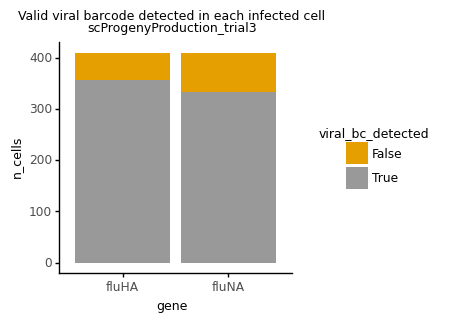

<ggplot: (8765303168118)>

In [8]:
viral_bc_detected_counts_df = (
    viral_barcode_freqs
    .groupby(['gene', 'viral_bc_detected'])
    ['cell_barcode']
    .nunique()
    .reset_index()
    .rename(columns={'cell_barcode': 'n_cells'}))

viral_bc_detected_counts = (
    p9.ggplot(viral_bc_detected_counts_df,
              p9.aes(x='gene',
                     y='n_cells',
                     fill='viral_bc_detected')) +
    p9.geom_bar(stat='identity') +
    p9.ggtitle('Valid viral barcode detected in each infected cell\n'
               f'{expt}') +
    p9.theme(figure_size=(3, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
    p9.scale_fill_manual([CBPALETTE[1], CBPALETTE[0]]))
display(viral_bc_detected_counts)

Plot whether missing viral barcodes are the result of that spedcific barcoded segment missing:

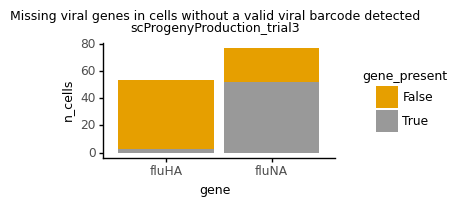

<ggplot: (8765974006038)>

In [9]:
missing_genes_df = (
    viral_barcode_freqs
    .query('viral_bc_detected == False')
    .groupby(['gene','gene_present'])
    ['cell_barcode']
    .nunique()
    .reset_index()
    .rename(columns={'cell_barcode': 'n_cells'}))

missing_genes = (
    p9.ggplot(missing_genes_df,
              p9.aes(x='gene',
                     y='n_cells',
                     fill='gene_present')) +
    p9.geom_bar(stat='identity') +
    p9.ggtitle('Missing viral genes in cells without a valid viral barcode detected\n'
               f'{expt}') +
    p9.theme(figure_size=(3, 1.5),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
    p9.scale_fill_manual([CBPALETTE[1], CBPALETTE[0]]))
display(missing_genes)

Annotate whether cell contributes progeny.

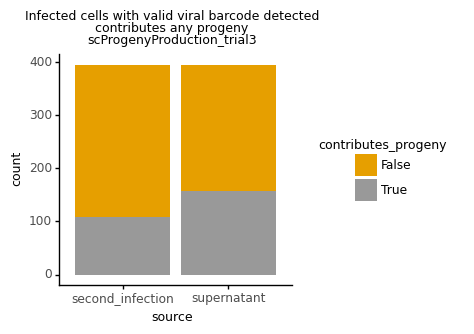

<ggplot: (8765290386131)>

In [10]:
contributes_progeny_by_cell_df = (
    viral_barcode_freqs
    .query('viral_bc_detected == True')
    .groupby(['cell_barcode',
              'source'])
    ['progeny_freq']
    .max()
    .reset_index()
    .rename(columns={'progeny_freq': 'max_progeny_freq'}))
contributes_progeny_by_cell_df['contributes_progeny'] = (
    contributes_progeny_by_cell_df['max_progeny_freq'] > progeny_detection_limit
)

contributes_progeny_by_cell = (
    p9.ggplot(contributes_progeny_by_cell_df,
              p9.aes(x='source',
                     fill='contributes_progeny')) +
    p9.geom_bar(stat='count') +
    p9.ggtitle('Infected cells with valid viral barcode detected\n'
               'contributes any progeny\n'
               f'{expt}') +
    p9.theme(figure_size=(3, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
    p9.scale_fill_manual([CBPALETTE[1], CBPALETTE[0]]))
display(contributes_progeny_by_cell)

Merge back into `viral_barcode_freqs` dataframe.  If viral barcode is not detected on gene, annotate as "viral barcode not detected".

In [11]:
viral_barcode_freqs = pd.merge(
    left=viral_barcode_freqs,
    right=contributes_progeny_by_cell_df,
    on=['cell_barcode', 'source'],
    how='left',
    validate='many_to_one'
)
viral_barcode_freqs['contributes_progeny'] = (
    viral_barcode_freqs['contributes_progeny'].fillna("valid viral bc not detected")
)

display(viral_barcode_freqs)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,gene,source,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,progeny_freq,n_viral_genes,frac_gene_UMIs,gene_present,viral_bc_detected,max_progeny_freq,contributes_progeny
0,AAACGAAGTAGACGTG,infected,wt,124341,4654,0.037429,fluHA,second_infection,AAGTAAGCGACATGAG,251.0,0.002019,0.00001,8,0.002566,True,True,0.000010,False
1,AAAGGATTCTGATGGT,infected,syn,80029,3893,0.048645,fluHA,second_infection,GTGGAGTCGCCAGTTC,114.0,0.001424,0.00001,8,0.003511,True,True,0.077933,True
2,AAAGGGCCAGGCTACC,infected,wt,20241,355,0.017539,fluHA,second_infection,AAAGTGATCCCCATAC,8.0,0.000395,0.00001,8,0.003607,True,True,0.000010,False
3,AAAGGGCCAGGCTACC,infected,wt,20241,355,0.017539,fluHA,second_infection,CATTTAACGCTGTGAG,15.0,0.000741,0.00001,8,0.003607,True,True,0.000010,False
4,AAAGGGCCAGGCTACC,infected,wt,20241,355,0.017539,fluHA,second_infection,CGTAGGATGTTGCGTC,31.0,0.001532,0.00001,8,0.003607,True,True,0.000010,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2261,TTTAGTCCATCATCCC,infected,wt,23766,1216,0.051166,fluNA,supernatant,TTGGACGCATTGCAAA,18.0,0.000757,0.00001,7,0.001389,True,True,0.000010,False
2262,TTTAGTCGTGCTCCGA,infected,wt,195173,6905,0.035379,fluNA,supernatant,NaN,NaN,NaN,NaN,8,0.000005,True,False,0.000010,False
2263,TTTCACAAGCCAAGCA,infected,wt,68424,2308,0.033731,fluNA,supernatant,GGTATCAGTTATTGTT,186.0,0.002718,0.00001,6,0.003201,True,True,0.000010,False
2264,TTTGATCTCGCATTGA,infected,wt,170914,10415,0.060937,fluNA,supernatant,NaN,NaN,NaN,NaN,8,0.007864,True,False,0.000010,False


Plot outcome for every cell, ranked by max viral progeny contribution:

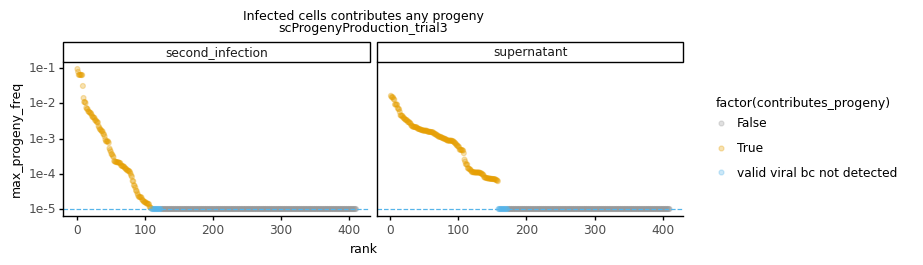

<ggplot: (8765290415538)>

In [12]:
max_progeny_rank_df = (
    viral_barcode_freqs
    [['cell_barcode', 'source', 'max_progeny_freq', 'contributes_progeny']]
    .drop_duplicates())
max_progeny_rank_df['max_progeny_freq'] = max_progeny_rank_df['max_progeny_freq'].fillna(progeny_detection_limit)
max_progeny_rank_df['rank'] = (
    max_progeny_rank_df
    .groupby('source')
    ['max_progeny_freq']
    .rank(ascending=False,
          method='first'))

max_progeny_rank = (
    p9.ggplot(max_progeny_rank_df,
              p9.aes(x='rank',
                     y='max_progeny_freq',
                     color='factor(contributes_progeny)')) +
    p9.geom_point(alpha=0.3) +
    p9.facet_grid('~source') +
    p9.geom_hline(yintercept=progeny_detection_limit, linetype='dashed', color=CBPALETTE[2]) +
    p9.ggtitle('Infected cells contributes any progeny\n'
               f'{expt}') +
    p9.scale_y_log10() +
    p9.theme(figure_size=(8, 2),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
    p9.scale_color_manual(CBPALETTE[0:]))

display(max_progeny_rank)

### Relationship between viral burden and progeny production

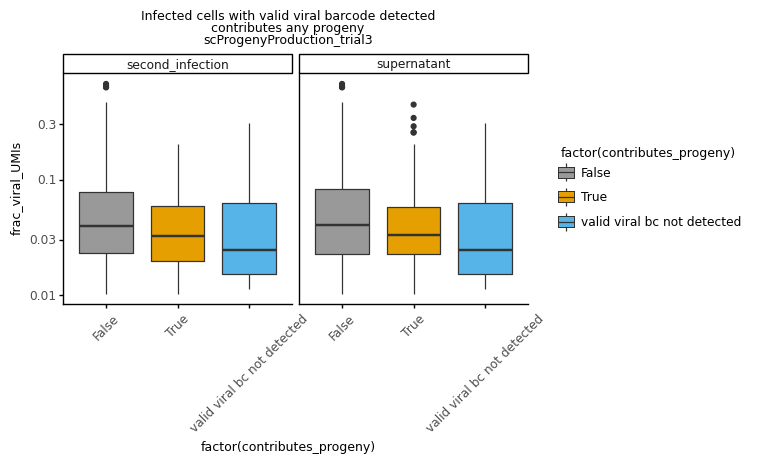

<ggplot: (8765290352270)>

In [13]:
viral_burden_contributes_progeny = (
    p9.ggplot((viral_barcode_freqs
               [['cell_barcode', 'contributes_progeny', 'source', 'frac_viral_UMIs']]
               .drop_duplicates()),
              p9.aes(x='factor(contributes_progeny)',
                     y='frac_viral_UMIs',
                     fill='factor(contributes_progeny)')) +
    p9.geom_boxplot() +
    p9.facet_grid('~source') +
    p9.ggtitle('Infected cells with valid viral barcode detected\n'
               'contributes any progeny\n'
               f'{expt}') +
    p9.scale_y_log10() +
    p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                axis_text_x=p9.element_text(rotation=45),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
    p9.scale_fill_manual(CBPALETTE[0:]))
display(viral_burden_contributes_progeny)

Bin on cells with all 8 genes:

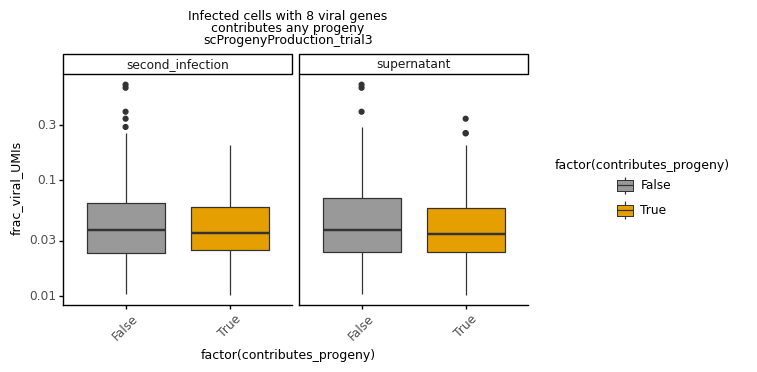

<ggplot: (8765290402446)>

In [14]:
viral_burden_contributes_progeny = (
    p9.ggplot((viral_barcode_freqs.query('n_viral_genes == 8')
               [['cell_barcode', 'contributes_progeny', 'source', 'frac_viral_UMIs']]
               .drop_duplicates()),
              p9.aes(x='factor(contributes_progeny)',
                     y='frac_viral_UMIs',
                     fill='factor(contributes_progeny)')) +
    p9.geom_boxplot() +
    p9.facet_grid('~source') +
    p9.ggtitle('Infected cells with 8 viral genes\n'
               'contributes any progeny\n'
               f'{expt}') +
    p9.scale_y_log10() +
    p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                axis_text_x=p9.element_text(rotation=45),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
    p9.scale_fill_manual(CBPALETTE[0:]))
display(viral_burden_contributes_progeny)

## Output

Save output figure

In [15]:
# save plot
print(f"Saving plot to {plot}")
p9.ggsave(plot=contributes_progeny_by_cell, filename=plot, verbose=False)

Saving plot to results/viral_progeny/scProgenyProduction_trial3_contributes_progeny_by_cell.pdf


Export whether each infected cell contributes viral progeny for each source and barcoded gene:

In [16]:
output_df = (
    viral_barcode_freqs[['cell_barcode', 
                         'source',
                         'max_progeny_freq',
                         'contributes_progeny']]
    .drop_duplicates())

output_df.to_csv(contributes_progeny_by_cell_csv, index=False)